In [1]:
import sys
import pymol
from pymol import cmd, stored

In [2]:
pymol.pymol_argv = ['pymol', '-qc'] # quiet / no GUI
stdout = sys.stdout
stderr = sys.stderr
pymol.finish_launching(['pymol', '-xiq'])
sys.stdout = stdout
sys.stderr = stderr

/Users/karen/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/Users/karen/anaconda/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


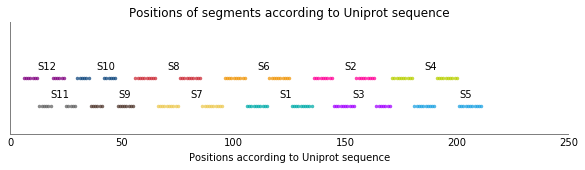

1886 unique mutations across all segments
238 natural unique mutations across all segments
There are 231 single mutations with known effects. They are found in 120 positions


Now the following variables are available:

- data: all data as a (sorted) dictionary in the form: 'segment_name': 'segment_data_as_pandas_dataframe'

- unique_single_mutations: a dictionary with all single mutations for every segment

- data_singles: a sorted dictionary in the form: 'segment_name': 'segment_data_as_pandas_dataframe' for genotypes containing a single substitution

- single_mut_fitness_dict: a dictionary in the form: 'single mutation' : 'fitness'

- data_known_mutations_only - a sorted dictionary in the form: 'segment_name': 'segment_data_as_pandas_dataframe', 
but only for those genotypes that consist of mutations with known effects (single mutant is measured).
For this dictionary, epistasis is measured for every genotype.

# # # # # # # # # # # # # # # # #




In [3]:
%run 'ks08_Epistasis_in_all_backgrounds.ipynb'
notebook_prefix = 'ks10'
image_counter = Counter()
session_counter = Counter()

### Plotting distribution of epistasis values

In [4]:
needed = False
if needed:
    bar_color = '#6e6e83'
    for segment in data:
        print segment, '...'
        folder_to_save = check_dir(os.path.join(figures_folder, 'epistasis_histograms', segment, ''))
        for mutA, mutB in ep_dict[segment]:
            ep = ep_dict[segment][mutA, mutB]
            if len(ep) > minimal_N:
                plot_better()
                mean, std = ep.mean(), ep.std()
                plt.axvline(mean, color='magenta')
                plt.axvline(std, color='orange')
                title = 'Segment %s \nepistasis between mutations %s and %s\nmean = %.2f, std = %.2f' %(segment.split('_')[0], 
                                                                                                    mutA, mutB,
                                                                                                   mean, std)
                plt.hist(ep.values, edgecolor='none', range=(-0.6, 0.6), bins=120, color=bar_color)
                plt.title(title)
                plt.xlabel('Epistasis')
                plt.ylabel('Number of different backgrounds')
                plt.xlim(-0.6,0.6)
                plt.axvline(0, color='gray', ls='-')
                plt.tight_layout()
                save_image(image_counter, title[:title.index('\nmean')], 
                           check_dir(os.path.join(folder_to_save, 'positions_'+mutA[:-1]+'-'+mutB[:-1], '')), 
                           notebook_prefix)
                plt.close()

## Epistasis vs predicted ddG

In [45]:
rosetta_folder = os.path.join(analysis_folder, 'Sasha', 'rosetta_runs', '')
predicted_ddG = pd.read_table(rosetta_folder + 'run-170503-results.csv')
predicted_ddG['mut_number'] = predicted_ddG['mut_list_Scer'].apply(lambda s: s.count(':')+1)
predicted_doubles = predicted_ddG[predicted_ddG['mut_number'] == 2].copy()

In [6]:
ep_dict_pandas = OrderedDict()
for segment in ep_dict:
    ep_dict_pandas[segment] = pd.DataFrame.from_dict(ep_dict[segment])

In [64]:
def get_segment_ep(segment, sorted_mut_pair):
    mutA, mutB = sorted_mut_pair[0], sorted_mut_pair[1]
    assert len(sorted_mut_pair) == 2
    assert mutA == sorted(list((mutA, mutB)), key=lambda m: int(m[:-1]))[0]

    ep_data = ep_dict_pandas[segment]
    try:
        return ep_data[mutA][mutB][~np.isnan(ep_data[mutA][mutB])]
    except:
#         print segment, mutA, mutB, len(sorted_mut_pair) == 2, ' -- failed to find'
        return pd.Series.from_array([0, np.nan])

def get_fraction_strong(ep_series, strong_epistasis_threshold=strong_epistasis_threshold):
    return 1. * len(ep_series[np.abs(ep_series) > strong_epistasis_threshold]) / len(ep_series)


predicted_doubles['ep_mean'] = predicted_doubles.apply(lambda df: get_segment_ep(df[u'segment'], df['mut_list_Scer'].split(':')).mean(),
                                                       axis=1)

predicted_doubles['ep_median'] = predicted_doubles.apply(lambda df: get_segment_ep(df[u'segment'], df['mut_list_Scer'].split(':')).median(),
                                                       axis=1)

predicted_doubles['ep_std'] = predicted_doubles.apply(lambda df: get_segment_ep(df[u'segment'], df['mut_list_Scer'].split(':')).std(),
                                                       axis=1)

predicted_doubles['ep_fraction_strong'] = predicted_doubles.apply(lambda df: get_fraction_strong(get_segment_ep(df[u'segment'], 
                                                                                                             df['mut_list_Scer'].split(':')),
                                                                                                strong_epistasis_threshold=0.15),
                                                       axis=1)

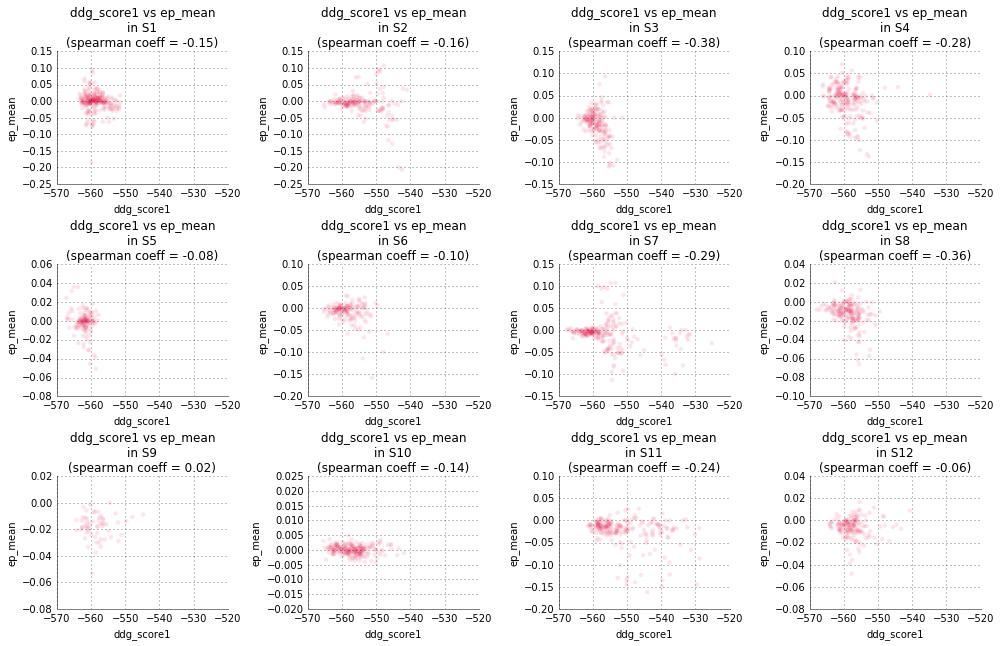

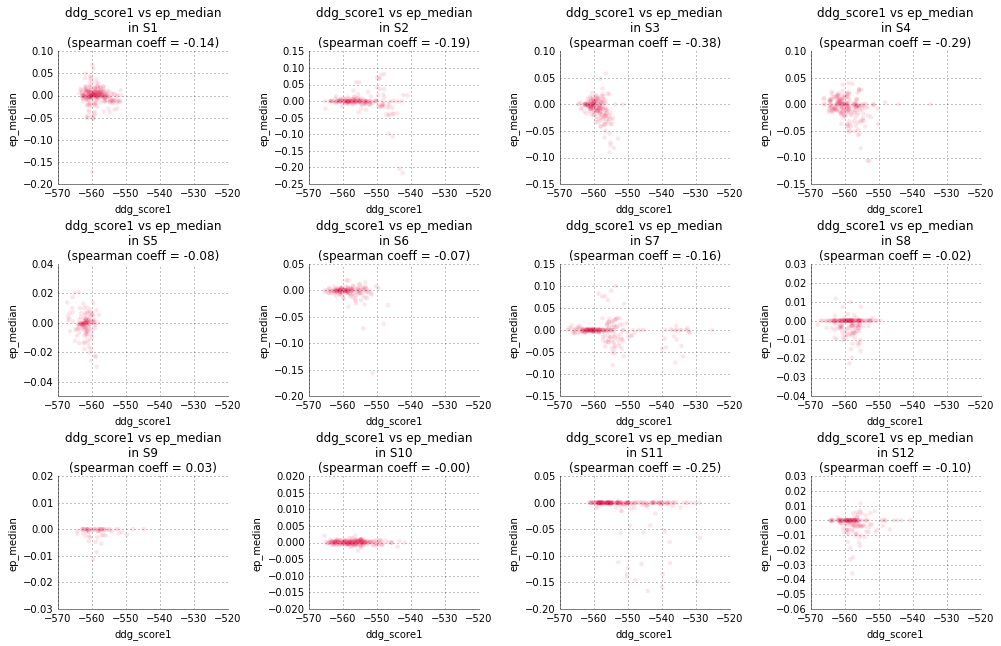

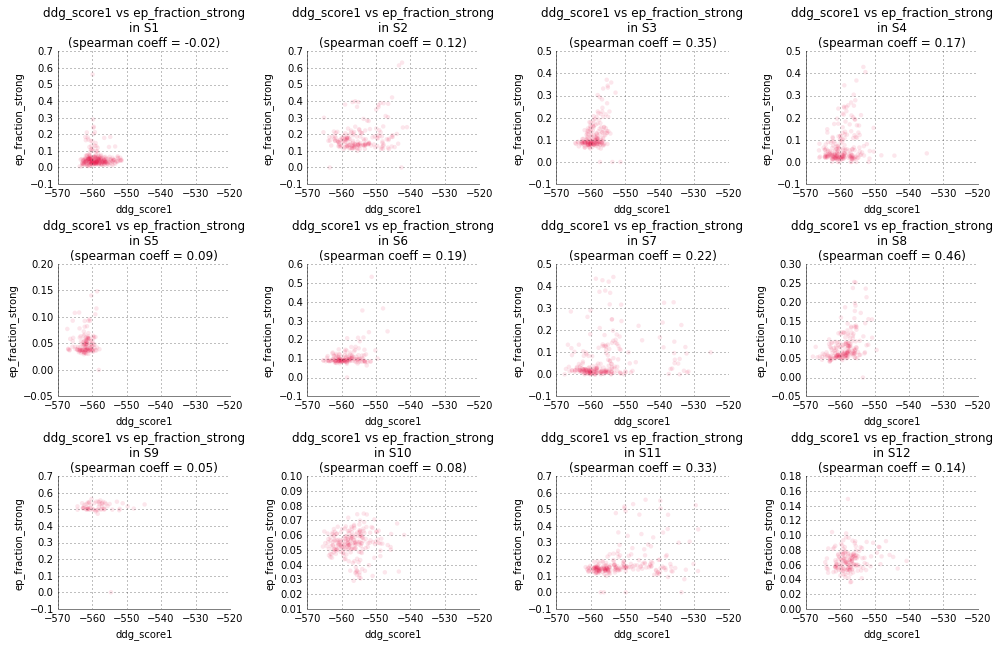

In [68]:
dot_color = '#E91348'
cols = [u'ep_mean', u'ep_median', u'ep_fraction_strong']

x = u'ddg_score1'
for y in cols:
    if x != y:
        plot_better(width=14, height=9)
        title ='%s vs %s in double mutants' % (x,y)
        for index, segment in enumerate(data.keys()):
            to_plot = predicted_doubles[predicted_doubles.segment == segment]
            ax = plt.subplot(3,4,index+1)
            improve_plot(ax)
            plt.scatter(to_plot[x],to_plot[y], edgecolor='none', alpha=0.1, color=dot_color)
            spearman = stats.spearmanr(to_plot[x],to_plot[y])
            subtitle = '%s vs %s\nin %s' % (x,y, segment.split('_')[0])
            subtitle += '\n(spearman coeff = %.2f)' %spearman[0]
            plt.title(subtitle)
        #     plt.ylim(0,0.7)
            plt.xlim(-570, -520)
        #     plt.axvline(0, color='gray')
            plt.xlabel(x)
            plt.ylabel(y)
        plt.tight_layout()
        save_image(image_counter, title, figures_folder, notebook_prefix)